If you dont have segmentation-models library downloaded already, then do-
`!pip install segmentation-models`

Read more about the library here: https://segmentation-models.readthedocs.io/en/latest/install.html

In [1]:
import numpy
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt
from segmentation_models import Unet
from segmentation_models.metrics import IOUScore
from segmentation_models.losses import JaccardLoss
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Segmentation Models: using `tf.keras` framework.


In [2]:
path = 'YOUR_PATH_TO_PARENT_DIRECTORY_OF_DATASET'

img_size = (128,128)
batch_size = 64
seed = 1

image_datagen = ImageDataGenerator(rescale=1./255)
mask_datagen = ImageDataGenerator(rescale=1./255)

#train images and their masks
train_image_generator = image_datagen.flow_from_directory(
                        path,
                        classes=['xtrain'],
                        target_size=img_size,
                        batch_size=batch_size,
                        class_mode=None, # None because we dont want labels to be returned, just images.
                        seed=seed, 
                        shuffle=False,
                        color_mode='rgb')

train_mask_generator = mask_datagen.flow_from_directory(
                        path,
                        classes=['ytrain'],
                        target_size=img_size,
                        batch_size=batch_size,
                        class_mode=None,# None because we dont want labels to be returned, just images.
                        seed=seed,
                        shuffle=False,
                        color_mode='grayscale')

train_generator = zip(train_image_generator, train_mask_generator)

# Validation images and their masks
# I created a separate validation data of 1000 images and masks taken from the training data.
# xval and yval folders contain those images and masks respectively.
val_image_generator = image_datagen.flow_from_directory(
                        path,
                        classes=['xval'],
                        target_size=img_size,
                        batch_size=batch_size,
                        class_mode=None,# None because we dont want labels to be returned, just images.
                        seed=seed,
                        shuffle=False,
                        color_mode='rgb')

val_mask_generator = mask_datagen.flow_from_directory(
                        path,
                        classes=['yval'],
                        target_size=img_size,
                        batch_size=batch_size,
                        class_mode=None, # None because we dont want labels to be returned, just images.
                        seed=seed,
                        shuffle=False,
                        color_mode='grayscale')

validation_generator = zip(val_image_generator, val_mask_generator)

# Test images and their masks
test_image_generator = image_datagen.flow_from_directory(
                        path,
                        classes=['xtest'],
                        target_size=img_size,
                        batch_size=batch_size,
                        class_mode=None, # None because we dont want labels to be returned, just images.
                        seed=seed,
                        shuffle=False,
                        color_mode='rgb')

test_mask_generator = mask_datagen.flow_from_directory(
                        path,
                        classes=['ytest'],
                        target_size=img_size,
                        batch_size=batch_size,
                        class_mode=None, # None because we dont want labels to be returned, just images.
                        seed=seed,
                        shuffle=False,
                        color_mode='grayscale')

test_generator = zip(test_image_generator, test_mask_generator)

Found 17697 images belonging to 1 classes.
Found 17697 images belonging to 1 classes.
Found 1001 images belonging to 1 classes.
Found 1001 images belonging to 1 classes.
Found 3740 images belonging to 1 classes.
Found 3740 images belonging to 1 classes.


In [3]:
print("train_image_gen. shape: ",len(train_image_generator)) # 17697/64 = 277 (batchsize)
print("train_mask_gen. shape: ",len(train_mask_generator))
print("train_image_gen.[0] shape: ",train_image_generator[0].shape) #each batch shape
print("train_mask_gen.[0] shape: ",train_mask_generator[0].shape)

print("\nval_image_gen. shape: ",len(val_image_generator)) #1001/64 = 16
print("val_image_gen.[0] shape: ",val_image_generator[0].shape) #each batch shape
print("val_mask_gen.[0] shape: ",val_mask_generator[0].shape)

print("\ntest_image_gen. shape: ",len(test_image_generator)) #3740/64 = 58.4
print("test_image_gen.[0] shape: ",test_image_generator[0].shape) #each batch shape
print("test_mask_gen.[0] shape: ",test_mask_generator[0].shape)

train_image_gen. shape:  277
train_mask_gen. shape:  277
train_image_gen.[0] shape:  (64, 128, 128, 3)
train_mask_gen.[0] shape:  (64, 128, 128, 1)

val_image_gen. shape:  16
val_image_gen.[0] shape:  (64, 128, 128, 3)
val_mask_gen.[0] shape:  (64, 128, 128, 1)

test_image_gen. shape:  59
test_image_gen.[0] shape:  (64, 128, 128, 3)
test_mask_gen.[0] shape:  (64, 128, 128, 1)


In [4]:
# Model 
# Since our principle class is "Person", and encoder- backbone ie VGG has been pre-trained for this class
# it is better to freeze the weights. Saves a lot of computation with good results.

model = Unet(encoder_freeze=True)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 6 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, None, None, 6 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, None, None, 6 0           block1_conv2[0][0]               
______________________________________________________________________________________________

In [5]:
# Loss function and metric taken from the segmentation-models library itself.
loss_func = JaccardLoss(per_image=True)
metric = IOUScore(per_image=True)

In [6]:
# Early stopping callback
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [7]:
model.compile(loss = loss_func, optimizer="adam", metrics=[metric])

In [8]:
%load_ext autotime

time: 453 µs (started: 2021-09-07 10:04:33 +05:30)


In [11]:
# couldnt calculate steps= len(generator)//batch_size because our gen. is zipped!
# Use steps argument everytime because otherwise it will go into infinite repeating dataset problem.

# I trained for a total 10 or 11 epochs.

model_history = model.fit(train_generator, steps_per_epoch = 277, validation_data=validation_generator,
           validation_steps = 16, batch_size=64, epochs=5, callbacks=[callback])

Epoch 1/5
277/277 [==============================] - 4216s 15s/step - loss: 0.0293 - iou_score: 0.9707 - val_loss: 0.0377 - val_iou_score: 0.9625
Epoch 2/5
277/277 [==============================] - 3832s 14s/step - loss: 0.0278 - iou_score: 0.9723 - val_loss: 0.0377 - val_iou_score: 0.9624
Epoch 3/5
277/277 [==============================] - 4413s 16s/step - loss: 0.0265 - iou_score: 0.9735 - val_loss: 0.0383 - val_iou_score: 0.9618
Epoch 4/5
277/277 [==============================] - 4318s 16s/step - loss: 0.0250 - iou_score: 0.9750 - val_loss: 0.0347 - val_iou_score: 0.9654
Epoch 5/5
277/277 [==============================] - 4343s 16s/step - loss: 0.0237 - iou_score: 0.9763 - val_loss: 0.0357 - val_iou_score: 0.9644
time: 5h 52min 2s (started: 2021-09-07 17:44:12 +05:30)


In [13]:
model.evaluate(test_generator, batch_size=64, steps=59, verbose=1) #len(test_gen is 59)

59/59 [==============================] - 431s 7s/step - loss: 0.0189 - iou_score: 0.9810


[0.018852343782782555, 0.9809785485267639]

time: 7min 11s (started: 2021-09-07 23:50:04 +05:30)


In [14]:
model.save('Unet_model')

INFO:tensorflow:Assets written to: Unet_model/assets
time: 7.69 s (started: 2021-09-08 00:03:23 +05:30)


## Visualising the results:

In [5]:
loss_func = JaccardLoss(per_image=True)
metric = IOUScore(per_image=True)

In [7]:
model = tf.keras.models.load_model('Unet_model', compile=False) 
# since we are using metrics/losses that are not pre-defined in tensorflow, it will give problem in
#deserialising the saved model.The work around is to load model without compiling it and then compile later.

In [8]:
model.compile(loss = loss_func, optimizer="adam", metrics=[metric])

In [41]:
path_test_img = 'ANY_TEST_IMAGE_PATH'

img_test_orig = cv2.imread(path_test_img)
h, w = img_test_orig.shape[0:2]

img_test_resized = cv2.resize(img_test_orig, (128,128))
img_test = np.asarray(img_test_resized)/255.0
img_test = img_test[np.newaxis,...]
print(img_test.shape)


(1, 128, 128, 3)


In [42]:
# Predicting the output from the trained model.
pred_img = model.predict(img_test)
print(pred_img.shape)

(1, 128, 128, 1)


In [44]:
pred_img = np.squeeze(pred_img) #removing extra 1-dimensions.

result = img_test_resized.copy()
result = cv2.cvtColor(result, cv2.COLOR_BGR2RGBA)

pred_img_copy = pred_img.copy()
pred_img_copy[pred_img_copy<0.5] = 0
pred_img_copy[pred_img_copy>=0.5] = 255 #binarising
print("Shape of result: " , result.shape)
print("Shape of pred_img_copy: " , pred_img_copy.shape)

result[:, :, 3] = pred_img_copy # adding mask in alpha channel
result = cv2.resize(result, (h,w)) # resizing back to original size
print("bg_removed shape: " , result.shape)

# https://stackoverflow.com/questions/63001988/how-to-remove-background-of-images-in-python

Shape of result:  (128, 128, 4)
Shape of pred_img_copy:  (128, 128)
bg_removed shape:  (128, 128, 4)


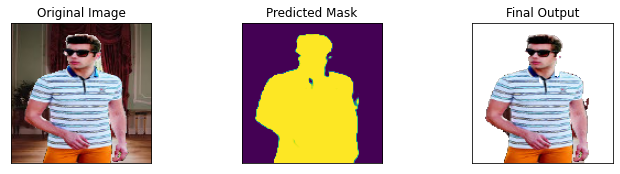

In [45]:
fig = plt.figure(figsize=(20, 15))
  
# setting values to rows and column variables
rows = 5
columns = 5

fig.add_subplot(rows, columns, 1)
plt.imshow(cv2.cvtColor(img_test_orig, cv2.COLOR_BGR2RGB))
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.title("Original Image")

fig.add_subplot(rows, columns, 2)
plt.imshow(pred_img)
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.title("Predicted Mask")

fig.add_subplot(rows, columns, 3)
plt.imshow(result)
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.title("Final Output")

plt.show()

Random test on a sample image is shown above.